# 1. Load Library

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
plt.style.use('ggplot')

# this is pandas table width setting
pd.set_option('display.max_columns', None)  

# 2. Data Processing

### Load Data

In [252]:
# load data, drop columns that are 'n/a'

data = [pd.read_csv(file, sep=' ', header=None) for file in ['data/train_FD001.txt','data/test_FD001.txt','data/RUL_FD001.txt']]
[f.drop(f.columns[[-1,-2]], axis=1, inplace=True) for f in data[0:2]]     # drop 'n/a' for test1/train1
data[2].drop(data[2].columns[[-1]], axis=1, inplace=True)                       # drop 'n/a' for test1/train1/rul1
header = ['id','cycle'] + ['setting'+str(i) for i in range(1,3+1)] + ['sensor'+str(j) for j in range(1,21+1)]
for k in range(2): data[k].columns = header

In [253]:
pd.DataFrame(np.array([[np.shape(dd)[0] for dd in data], [np.shape(ff)[1] for ff in data]]),
             index=['#columns', '#rows'], columns=['train1','test1','URL1'])

train1  test1  URL1
#columns   20631  13096   100
#rows         26     26     1

### Create Labels

In [254]:
# number of warning cycle, w1 = 30, w2 = 15

w1, w2 = 30, 15

In [255]:
# training data
# add rul' (remaining useful life) = 'max' - 'cycle' for regression
# add w1, w2 for multi-class classification

for item in data[0:1]:
    item['rul'] = item.groupby('id')['cycle'].transform('max') - item['cycle']
    item['w1'] = np.where(item['rul'] > w1, 0, 1)
    item['w2'] = np.where(item['rul'] > w2, 0, 1)
    item['w2'] = item['w2'] + item['w1']

In [256]:
# handle ground truth data first

data[2].columns = ['truth']
data[2]['id'] = data[2].index + 1

In [75]:
# testing data 'rul' considers ground truth data from RUL_FD00*.txt

for index in range(2):
    data[index] = data[index].merge(data[2], on=['id'], how='left')
    data[index]['rul'] = data[index].groupby('id')['cycle'].transform('max') + data[index]['truth'] - data[index]['cycle']
    data[index]['w1'] = np.where(data[index]['rul'] > w1, 0, 1)
    data[index]['w2'] = np.where(data[index]['rul'] > w2, 0, 1)
    data[index]['w2'] = data[index]['w2'] + data[index]['w1']
    data[index].drop(['truth'], axis = 1, inplace=True)

In [78]:
# assign to separate data sets for easier to manage

train, test, RUL = data

### Time Series

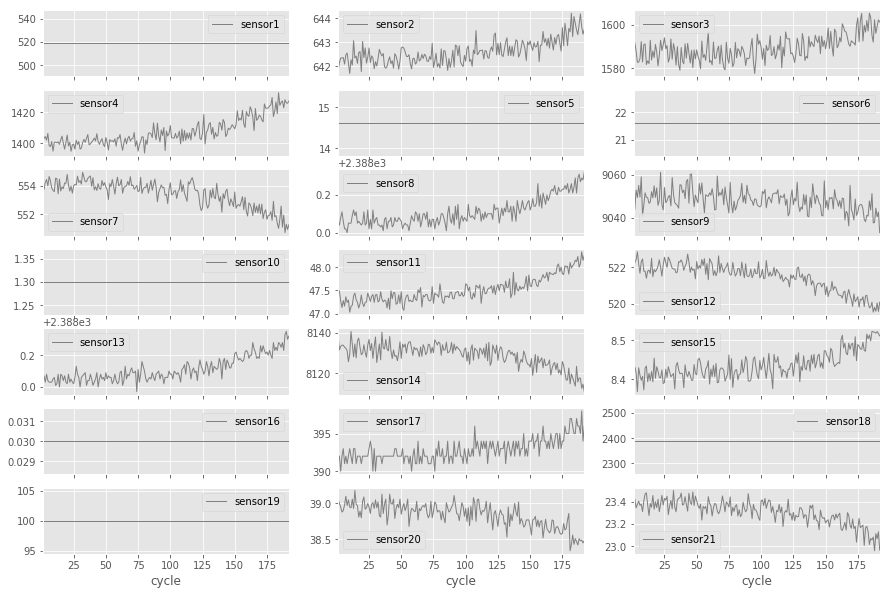

In [80]:
# look at one group of training sensor data over cycle time 

_, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)
for index, ax in enumerate(axes.ravel()):
    train[train['id']==1].plot(x='cycle', y='sensor'+str(index+1), ax=ax, color='gray', linewidth=1)
plt.show()

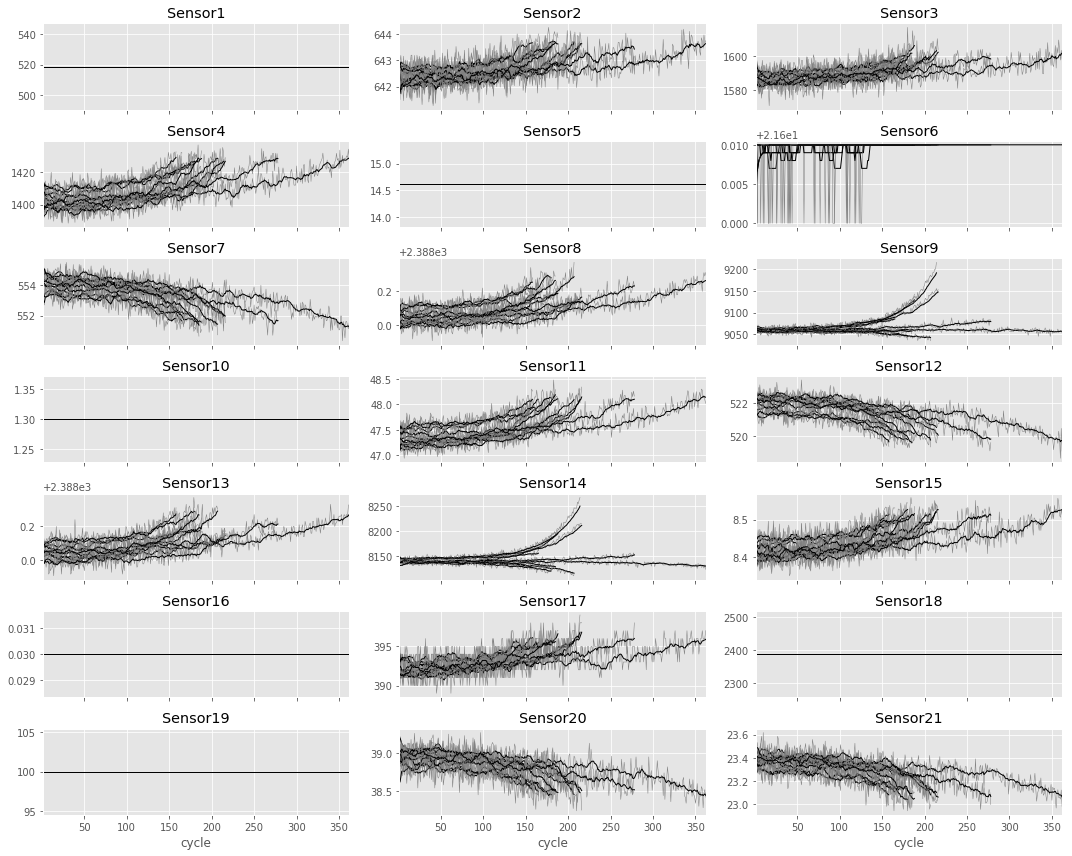

In [90]:
# look at 10 groups of sensor data vs their moving average

np.random.seed(1234)
random10 = np.random.choice(Train['id'].unique(), size=10, replace=False)
train_random10 = train[Train['id'].isin(random10)].copy()

_, axes1 = plt.subplots(7, 3, figsize=(15, 12), sharex=True)
for index, ax in enumerate(axes1.ravel()):
    for unit_id, group in train_random10.groupby('id'):
        (group
            .plot(x='cycle', y='sensor'+str(index+1), ax=ax, color='gray', linewidth=0.5, legend=False))
        (group
            .rolling(window=10, on = 'cycle', min_periods=1)
            .mean().fillna(0)
            .plot(x='cycle', y='sensor'+str(index+1), ax=ax, color='black', linewidth=1, legend=False))
    ax.set_title(('sensor'+str(index+1)).title())

plt.tight_layout()
plt.show()

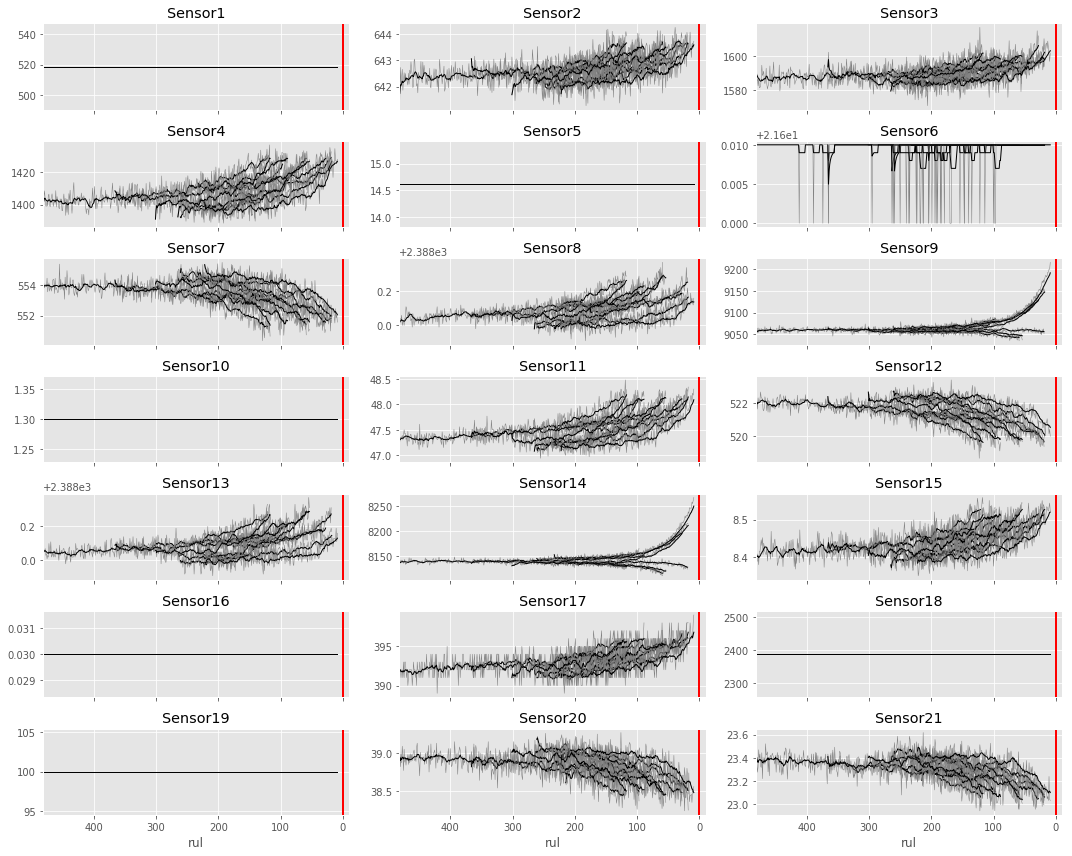

In [91]:
# look at 10 groups of sensor data till end of life
# red line is end of life

_, axes2 = plt.subplots(7, 3, figsize=(15, 12), sharex=True)
for index, ax in enumerate(axes2.ravel()):
    for unit_id, group in train_random10.groupby('id'):
        (group
            .plot(x='rul', y='sensor'+str(index+1), ax=ax, color='gray', linewidth=0.5, legend=False))
        (group
            .rolling(window=10, on = 'rul', min_periods=1)
            .mean().fillna(0)
            .plot(x='rul', y='sensor'+str(index+1), ax=ax, color='black', linewidth=1, legend=False))
    ax.set_title(('sensor'+str(index+1)).title())
    ax.axvline(x=0, color='r', linestyle='solid', linewidth=2)
    ax.set_xlim(train_random10['rul'].max(), -10)
    
plt.tight_layout()
plt.show()

### Feature Drop

In [160]:
# sensor 1, 5, 6, 10, 16, 18, 19 are 0 value; setting3 is constant

drop_list = ['setting3','sensor1','sensor5','sensor6','sensor10','sensor16','sensor18','sensor19']
train_d, test_d = train.copy(), test.copy()
train_d.drop(drop_list, axis=1, inplace=True)
test_d.drop(drop_list, axis=1, inplace=True)

### Feature Scale

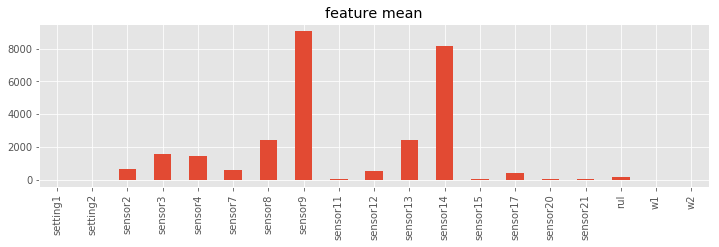

In [161]:
# the features are in quite different scales, makes sense to normalize

train_d.iloc[:, 2:25].mean().plot(kind='bar', figsize=(12,3), title='feature mean')

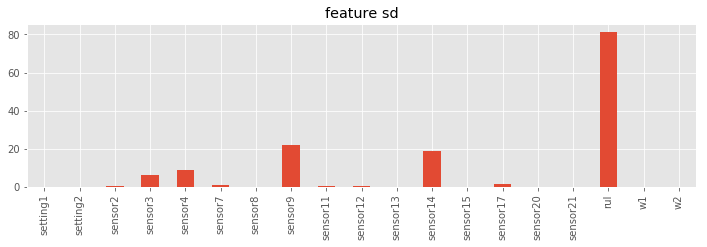

In [162]:
train_d.iloc[:, 2:25].std().plot(kind='bar', figsize=(12,3), title='feature sd')

### Raw Feature

In [163]:
train_d.to_pickle('data/train_d.pkl')
test_d.to_pickle('data/test_d.pkl')

### Rolling Average

In [169]:
# Save data sets with rolling window = 10

train_f, test_f = train_d.iloc[:,0:18].copy(), test_d.iloc[:,0:18].copy()
train_r = train_f.groupby(['id']).apply(lambda x: x.rolling(window=10, min_periods=1).mean().fillna(0))
test_r = test_f.groupby(['id']).apply(lambda x: x.rolling(window=10, min_periods=1).mean().fillna(0))
train_r = pd.concat([train_d[['id','cycle']], train_r.iloc[:,2:18], train_d.iloc[:,18:22]], axis=1)
test_r = pd.concat([test_d[['id','cycle']], test_r.iloc[:,2:18], test_d.iloc[:,18:22]], axis=1)

train_r.to_pickle('data/train_r.pkl')
test_r.to_pickle('data/test_r.pkl')

### Rolling + Normalization

In [179]:
# Save data sets with rolling window = 10 and normalization

from sklearn import preprocessing
scaler_train = preprocessing.MinMaxScaler()
scaler_test = preprocessing.MinMaxScaler()

train_rf, test_rf = train_r.iloc[:,2:19].copy(), test_r.iloc[:,2:19].copy()
train_r_n = pd.DataFrame(scaler_train.fit_transform(train_rf), columns=train_r.columns[2:19])
test_r_n = pd.DataFrame(scaler_test.fit_transform(test_rf), columns=test_r.columns[2:19])
train_r_n = pd.concat([train_r[['id','cycle']], train_r_n, train_r[['w1','w2']]], axis=1) 
test_r_n = pd.concat([test_r[['id','cycle']], test_r_n, test_r[['w1','w2']]], axis=1) 

train_r_n.to_pickle('data/train_r_n.pkl')
test_r_n.to_pickle('data/test_r_n.pkl')

## This is the end of baseline data processing

In [236]:
group_id = np.unique(train_d['id'])
pd.DataFrame(np.array(train_d.groupby(['id']).size()).reshape(1,100), index=['group size'], columns=['gp'+str(i) for i in group_id])

gp1  gp2  gp3  gp4  gp5  gp6  gp7  gp8  gp9  gp10  gp11  gp12  \
group size  192  287  179  189  269  188  259  150  201   222   240   170   

            gp13  gp14  gp15  gp16  gp17  gp18  gp19  gp20  gp21  gp22  gp23  \
group size   163   180   207   209   276   195   158   234   195   202   168   

            gp24  gp25  gp26  gp27  gp28  gp29  gp30  gp31  gp32  gp33  gp34  \
group size   147   230   199   156   165   163   194   234   191   200   195   

            gp35  gp36  gp37  gp38  gp39  gp40  gp41  gp42  gp43  gp44  gp45  \
group size   181   158   170   194   128   188   216   196   207   192   158   

            gp46  gp47  gp48  gp49  gp50  gp51  gp52  gp53  gp54  gp55  gp56  \
group size   256   214   231   215   198   213   213   195   257   193   275   

            gp57  gp58  gp59  gp60  gp61  gp62  gp63  gp64  gp65  gp66  gp67  \
group size   137   147   231   172   185   180   174   283   153   202   313   

            gp68  gp69  gp70  gp71  gp72  gp73  gp74  gp75  gp76  gp77  gp78  \
group size   199   362   137   208   213   213   166   229   210   154   231   

            gp79  gp80  gp81  gp82  gp83  gp84  gp85  gp86  gp87  gp88  gp89  \
group size   199   185   240   214   293   267   188   278   178   213   217   

            gp90  gp91  gp92  gp93  gp94  gp95  gp96  gp97  gp98  gp99  gp100  
group size   154   135   341   155   258   283   336   202   156   185    200

In [249]:
data[1][0:10]

id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1    0.0023    0.0003     100.0   518.67   643.02  1585.29   
1   1      2   -0.0027   -0.0003     100.0   518.67   641.71  1588.45   
2   1      3    0.0003    0.0001     100.0   518.67   642.46  1586.94   
3   1      4    0.0042    0.0000     100.0   518.67   642.44  1584.12   
4   1      5    0.0014    0.0000     100.0   518.67   642.51  1587.19   
5   1      6    0.0012    0.0003     100.0   518.67   642.11  1579.12   
6   1      7   -0.0000    0.0002     100.0   518.67   642.11  1583.34   
7   1      8    0.0006   -0.0000     100.0   518.67   642.54  1580.89   
8   1      9   -0.0036    0.0000     100.0   518.67   641.88  1593.29   
9   1     10   -0.0025   -0.0001     100.0   518.67   642.07  1585.25   

   sensor4  sensor5  sensor6  sensor7  sensor8  sensor9  sensor10  sensor11  \
0  1398.21    14.62    21.61   553.90  2388.04  9050.17       1.3     47.20   
1  1395.42    14.62    21.61   554.85  2388.01  9054.42       1.3     47.50   
2  1401.34    14.62    21.61   554.11  2388.05  9056.96       1.3     47.50   
3  1406.42    14.62    21.61   554.07  2388.03  9045.29       1.3     47.28   
4  1401.92    14.62    21.61   554.16  2388.01  9044.55       1.3     47.31   
5  1395.13    14.62    21.61   554.22  2388.00  9050.96       1.3     47.26   
6  1404.84    14.62    21.61   553.89  2388.05  9051.39       1.3     47.31   
7  1400.89    14.62    21.61   553.59  2388.05  9052.86       1.3     47.21   
8  1412.28    14.62    21.61   554.49  2388.06  9048.55       1.3     47.37   
9  1398.64    14.62    21.61   554.28  2388.04  9051.95       1.3     47.14   

   sensor12  sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  \
0    521.72   2388.03   8125.55    8.4052      0.03       392      2388   
1    522.16   2388.06   8139.62    8.3803      0.03       393      2388   
2    521.97   2388.03   8130.10    8.4441      0.03       393      2388   
3    521.38   2388.05   8132.90    8.3917      0.03       391      2388   
4    522.15   2388.03   8129.54    8.4031      0.03       390      2388   
5    521.92   2388.08   8127.46    8.4238      0.03       392      2388   
6    522.01   2388.06   8134.97    8.3914      0.03       391      2388   
7    522.09   2388.06   8125.93    8.4213      0.03       393      2388   
8    522.03   2388.05   8134.15    8.4353      0.03       391      2388   
9    522.00   2388.06   8134.08    8.4093      0.03       391      2388   

   sensor19  sensor20  sensor21  rul  w1  w2  
0     100.0     38.86   23.3735  142   0   0  
1     100.0     39.02   23.3916  141   0   0  
2     100.0     39.08   23.4166  140   0   0  
3     100.0     39.00   23.3737  139   0   0  
4     100.0     38.99   23.4130  138   0   0  
5     100.0     38.91   23.3467  137   0   0  
6     100.0     38.85   23.3952  136   0   0  
7     100.0     39.05   23.3224  135   0   0  
8     100.0     39.10   23.4521  134   0   0  
9     100.0     38.87   23.3820  133   0   0